# Elements of Data Science

# COMS W4995 007 2018 3


## Week 7: Feature Selection, Model Evaluation and Selection

## Reading: 

- TODO!!

## Today

- Model Evalation and Selection
- Regression
    - MSE
    - Residuals
    - R^2

- Bias, Variance tradeoff
- Overfitting and Underfitting
    - the Train/Test split
    - Validation Curve
- Cross Validation
- Grid Search

- Classification
    - Accuracy and Error
    - Confusion Matrix
    - Precision vs. Recall
    - ROC
    - AUC

- Feature Selection
    - Univariate
    - Stepwise
    - Model Based

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore

# To suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(123)
%matplotlib inline

## Supervised Learning
- $y \in R$ or $\{1,2,..,k\}$
- dataset = $(X,y) = (x,y)_{i=1:n}$

## Model Evaluation and Selection : Regression

In [2]:
# load taxi example
df = pd.read_csv('../data/yellow_tripdata_2017-01_subset10000rows.csv',
                 header=0,
                 index_col=0,
                 parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

# hour of pickup
df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour
# trip time in minutes
df['total_time'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds/60
# subset features
df = df[['trip_distance','pickup_hour','total_time','tip_amount']]

# drop some outliers
df.drop(df[df.trip_distance == 0].index, inplace=True)
df.drop(df[df.total_time < 1].index, inplace=True)
df.drop(df[df.total_time > 60*3].index, inplace=True)

df.drop(df[df.tip_amount == 0].index,inplace=True)

In [3]:
# bin and onehot pickup time
df['pickup'] = pd.cut(df.pickup_hour, bins=[0,7,20,24],
                        include_lowest=True,
                        labels=['early','day','late'],
                     )
df = pd.get_dummies(df,columns=['pickup'], drop_first=True)
df = df.drop('pickup_hour', axis=1)

# scale numerical features
df.trip_distance = zscore(df.trip_distance)
df.total_time = zscore(df.total_time)

# generate dataset for regression
feature_cols = ['trip_distance','total_time','pickup_day','pickup_late']
target_col = 'tip_amount'

X = df[feature_cols]
y = df[target_col]
n,m = X.shape

print(n,m)

6365 4


In [4]:
from sklearn.linear_model import LinearRegression

# instantiate and train model
lr = LinearRegression().fit(X,y)

In [5]:
# predict values using trained model
y_pred = lr.predict(X)

## Aside: model interpretation

In [6]:
lr.intercept_

2.576642246386925

In [7]:
list(zip(X.columns,lr.coef_))

[('trip_distance', 1.6383094530478848),
 ('total_time', 0.5240206042713936),
 ('pickup_day', 0.16948924516656158),
 ('pickup_late', 0.08255257656982048)]

## How well does the model perform?

### Root Mean Squared Error

- in (0, inf)
- describes accuracy

$$
RMSE = \sqrt{\frac{1}{n}\sum \left(\hat{y}_i - y_i\right)^2}
$$

In [8]:
_    =                     (y_pred - y)     # difference
_    =                     (y_pred - y)**2  # remove sign
_    =                 sum((y_pred - y)**2)  # sum up
mse  =         (1/n) * sum((y_pred - y)**2)  # avg sqr difference
rmse = np.sqrt((1/n) * sum((y_pred - y)**2)) # back into orig scale

In [9]:
print('MSE = {:0.2f}, RMSE = {:0.2f}'.format(mse, rmse))

MSE = 1.58, RMSE = 1.26


In [10]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y,y_pred))

1.2588382075669802

In [11]:
def calc_rmse(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

### $R^2$

- best is 1
- describes amount of variance explained by the model

$$
R^2 = 1 - \frac{\sum \left(\hat{y}_i - y_i\right)^2}{\sum \left(\bar{y} - y_i\right)^2}
$$

In [12]:
from sklearn.metrics import r2_score

r2 = r2_score(y,y_pred)

print('r^2: {}'.format(r2))

r^2: 0.730700809047159


In [13]:
# R^2 is zero when predicting the mean

from sklearn.dummy import DummyRegressor

dummyr = DummyRegressor(strategy='mean')
dummyr.fit(X,y)
y_pred_dummy = dummyr.predict(X)

print('r^2: {}'.format(r2_score(y,y_pred_dummy)))

r^2: 0.0


In [14]:
# R^2 can be negative

y_pred_bad = [1000] * len(y)

print('r^2: {}'.format(r2_score(y,y_pred_bad)))

r^2: -169022.40662354752


### Evaluating Residuals

residual error: $y - \hat{y}$

In [15]:
residuals = y - y_pred

In [16]:
def plot_residuals(y,y_pred):
    residuals = y - y_pred # calculate residuals
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    _ = sns.distplot(y,ax=ax[0])
    _ = ax[1].scatter(y_pred,residuals)
    _ = ax[1].plot([np.min(y_pred),np.max(y_pred)],[0,0], color='k')
    _ = ax[1].set_ylabel('residuals')
    _ = ax[1].set_xlabel('y_pred')

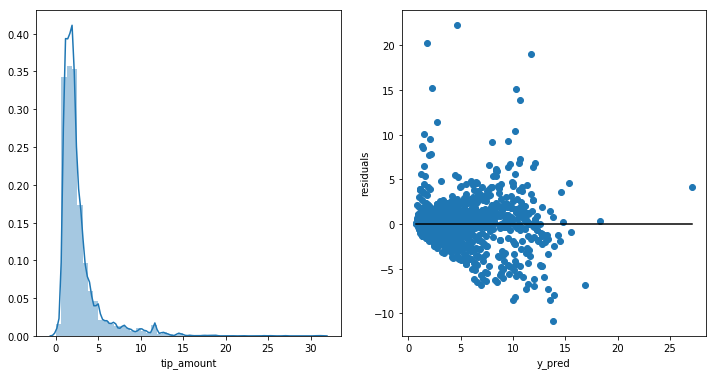

In [17]:
plot_residuals(y,y_pred)

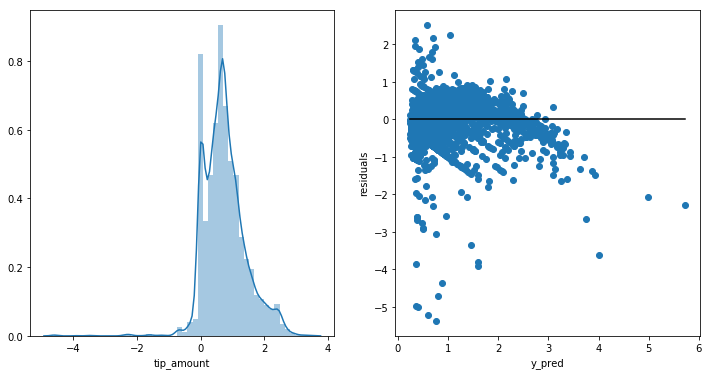

In [18]:
lr2 = LinearRegression().fit(X,np.log(y))
y_pred2 = lr2.predict(X)

plot_residuals(np.log(y),y_pred2)

### Aside: Anscombe's Quartet

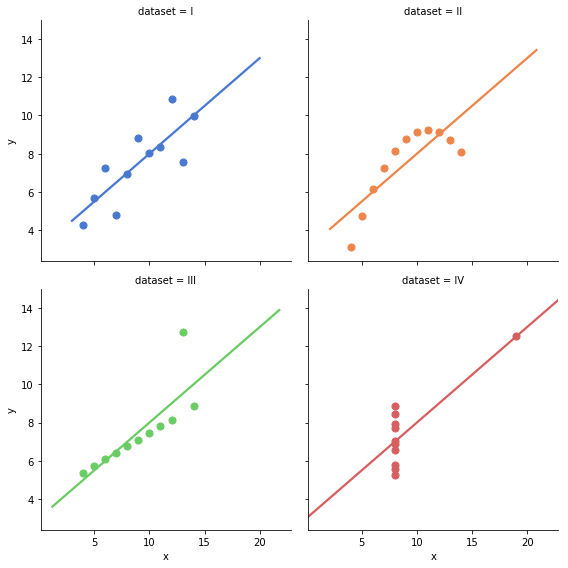

In [19]:
# Load the example dataset for Anscombe's quartet
anscombe = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
_ = sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=anscombe,
               col_wrap=2, ci=None, palette="muted", height=4,
               scatter_kws={"s": 50, "alpha": 1})

In [20]:
for num in ['I','II','III','IV']:
    ds = anscombe.loc[anscombe.dataset==num]
    Xa,ya = ds.x.values.reshape(-1,1), ds.y
    ya_pred = LinearRegression().fit(Xa,ya).predict(Xa)
    print('DS {:4s} RMSE = {:0.2f}'.format(num, calc_rmse(ya,ya_pred)))

DS I    RMSE = 1.12
DS II   RMSE = 1.12
DS III  RMSE = 1.12
DS IV   RMSE = 1.12


In [21]:
# caluculate residuals for each dataset
resids = []
for num in ['I','II','III','IV']:
    ds = anscombe.loc[anscombe.dataset==num]
    Xa,ya = ds.x.values.reshape(-1,1), ds.y
    ya_pred = LinearRegression().fit(Xa,ya).predict(Xa)
    resids.append(pd.DataFrame(list(zip([num]*len(ya),Xa[:,0],ya,ya_pred,ya_pred - ya)),
                               columns = ['dataset','x','y','y_pred','resid']))
df_resids = pd.concat(resids)

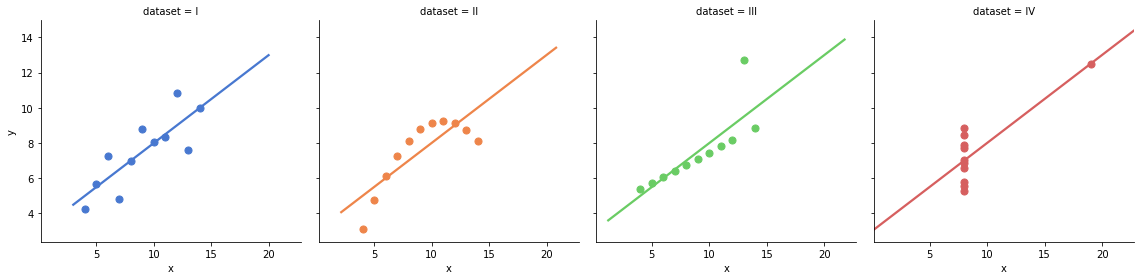

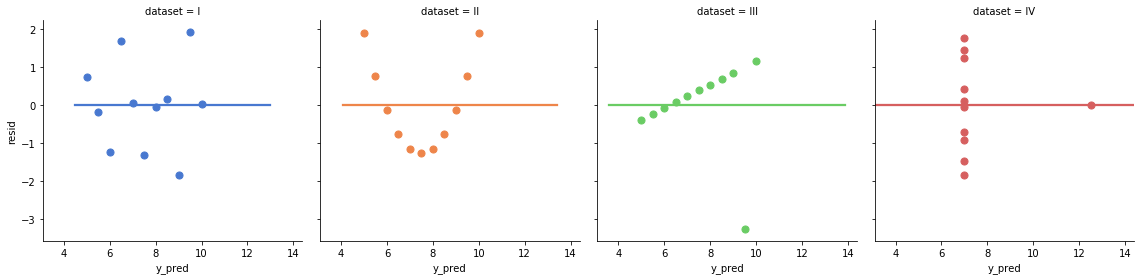

In [22]:
# Show the residuals for each dataset
_ = sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df_resids,
               col_wrap=None, ci=None, palette="muted", height=4,
               scatter_kws={"s": 50, "alpha": 1})
_ = sns.lmplot(x="y_pred", y="resid", col="dataset", hue="dataset", data=df_resids,
               col_wrap=None, ci=None, palette="muted", height=4,
               scatter_kws={"s": 50, "alpha": 1})

### How well are we doing? Need something to compare against!

In [23]:
from sklearn.dummy import DummyRegressor

dummyr = DummyRegressor(strategy='mean').fit(X,y)
dummyr.fit(X,y)
y_pred_dummy = dummyr.predict(X)
print('{:5s} rmse = {:0.2f}'.format('dummy',calc_rmse(y,y_pred_dummy)))

y_pred_lr = lr.predict(X)
print('{:5s} rmse = {:0.2f}'.format('lr',calc_rmse(y,y_pred_lr)))

dummy rmse = 2.43
lr    rmse = 1.26


### But why can't we stop here?

Evaluating on the training set!

We might want to generalize (predict on a new, unseen observation)!

## Train/Test split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [25]:
# train on the training set
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
# evaluate on the test set
y_pred = lr.predict(X_test)

In [27]:
mse = mean_squared_error(y_test,y_pred)
rmse = calc_rmse(y_test, y_pred)
print('MSE = {:0.2f}, RMSE = {:0.2f}'.format(mse,rmse))

MSE = 1.60, RMSE = 1.26


## Overfitting and Underfitting

In [28]:
lr = LinearRegression()
lr.fit(X,y)
lr.score(X,y) # r2 score

0.730700809047159

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
poly = make_pipeline(PolynomialFeatures(degree=10),
                     LinearRegression(fit_intercept=False))

poly.fit(X,y)
poly.score(X,y) # r2 score

0.7884990581643264

### Bias vs. Variance

<img src='images/bias-variance-tradeoff.png'>

<img src="images/05.03-bias-variance.png">

### How to tell if you're Over/Underfitting: Test/Hold-out-set

**Generalization** (aka out-of-sample error): a measure of how accurately an algorithm is able to predict outcome values for previously unseen data.

<img src="images/05.03-bias-variance-2.png">

**Train**: used to train model

**Test, Validation, out-of-sample**: used to evaluate model

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.5,
                                                    random_state=0)

In [31]:
lr.fit(X_train,y_train)
lr.score(X_test,y_test) # r2 score

0.7441367125775096

In [32]:
poly.fit(X_train,y_train)
poly.score(X_test,y_test) # r2 score

-93485.0650620013

Avoid overfitting and underfitting by:

- underfitting: More complicated/more flexible model
- overfitting: Less complicated/more flexible model
- both: Gather more training samples
- both: Gather new features

### Really shouldn't look at the test set till the end
### But then how do we find a good model?

### Cross-Validation

<img src="https://cdn-images-1.medium.com/max/1600/1*J2B_bcbd1-s1kpWOu_FZrg.png">

In [33]:
from sklearn.model_selection import cross_val_score

train_scores = cross_val_score(lr, X_train, y_train, cv=3) # r^2
print(train_scores)
print(np.median(train_scores))

[0.77870921 0.6397971  0.7350483 ]
0.7350482956014587


In [34]:
train_scores = cross_val_score(poly, X_train, y_train, cv=3) # r^2
print(train_scores)
print(np.median(train_scores))

[-1.58569732e+06 -4.59704329e+08 -7.00666724e+11]
-459704328.5662346


### Choosing hyper-parameters: Validation Curve

In [35]:
from sklearn.preprocessing import RobustScaler

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(RobustScaler(),
                         PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [36]:
from sklearn.model_selection import validation_curve

degree = np.arange(0,5)
train_score, validation_score = validation_curve(PolynomialRegression(),
                                                 X_train, y_train,
                                                 'polynomialfeatures__degree',
                                                 degree, cv=3)

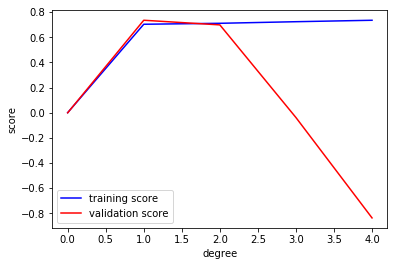

In [37]:
_ = plt.plot(degree, np.median(train_score,1), color='b',label='training score')
_ = plt.plot(degree, np.median(validation_score,1), color='r', label='validation score')
_ = plt.xlabel('degree'), plt.ylabel('score')
_ = plt.legend(loc='best')

### Searching for the best model: GridSearch


In [38]:
from sklearn.model_selection import GridSearchCV

params = {'polynomialfeatures__degree':[1,2,4],
          'linearregression__normalize': [False, True]}

pr = PolynomialRegression()

gscv = GridSearchCV(pr,params,cv=3)

gscv.fit(X_train,y_train)

print(gscv.best_params_)

{'linearregression__normalize': False, 'polynomialfeatures__degree': 1}


In [39]:
print(gscv.best_estimator_.score(X_test,y_test))

0.7441367125775096


In [40]:
from sklearn.ensemble import RandomForestRegressor

params = {'n_estimators':[10,50,100],
          'max_depth':[2,5,10]}

gscv = GridSearchCV(RandomForestRegressor(),params,cv=3)

gscv.fit(X_train,y_train)

print(gscv.best_params_)
print(gscv.best_estimator_.score(X_test,y_test))

/home/bgibson/anaconda3/envs/coms007/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'max_depth': 5, 'n_estimators': 50}
0.6817220100479037


### Alternative: Regularization

- reduce number of independent variables (feature selection)


- 'minimize' the coefficients on variables

### Regularization: reduce the effect of features

- Ridge Regression ($\ell^2$): drives coefficents small

- LASSO ($\ell^1$): drives coefficients to zero

- ElasticNet ($\ell^2 + \lambda \ell^1$)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=0)

In [78]:
# fit and evaluate a standard linear regression

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
rmse = calc_rmse(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
print('RMSE: {}'.format(rmse))
print(' R^2: {}'.format(r2))

RMSE: 1.317533338861431
 R^2: 0.7370538208360717


In [79]:
lr.coef_

array([1.62354482, 0.48999263, 0.14288349, 0.06104886])

In [80]:
# fit using LASSO regression

from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
rmse = calc_rmse(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print('    RMSE: {}'.format(rmse))
print('     r^2: {}'.format(r2))

    RMSE: 1.8063363819319695
     r^2: 0.5057565799049155


In [81]:
# learned coefficients
lasso.coef_

array([ 1.00159028,  0.        ,  0.        , -0.        ])

In [83]:
# which features did we keep?
X.columns[lasso.coef_!=0]

Index(['trip_distance'], dtype='object')

In [84]:
# finding a balance between l1 and l2 using elasticnet
from sklearn.linear_model import ElasticNetCV

en = ElasticNetCV(l1_ratio=[.1, .5, .9, .95, .99,1])

en.fit(X_train, y_train)
y_pred = en.predict(X_test)
rmse = calc_rmse(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print('l1_ratio: {}'.format(en.l1_ratio_))
print('    RMSE: {}'.format(rmse))
print('     r^2: {}'.format(r2))

l1_ratio: 1.0
    RMSE: 1.318156902097932
     r^2: 0.7368048671799131


## Review

- Regression: RMSE
- Regression: $R^2$
- Bias/Variance Tradeoff
- Overfitting/Underfitting
- Dummy Learner
- Train/Test split
- Cross-Validation
- Grid-Search
- Regularization

## Model Evaluation and Selection : Classification

df = pd.read_csv('../data/loan_data.csv', header=0, index_col=0)

df = pd.concat([pd.get_dummies(df.outcome,drop_first=True),
                df.loan_amnt,
                pd.get_dummies(df.purpose_,prefix='purpose')],axis=1)

feature_cols = df.columns[1:]
target_col = df.columns[0]

X = df[feature_cols]
y = df[target_col]

df.head()

In [85]:
y = df.tip_amount > df.tip_amount.median()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=.25,
                                                    stratify=y,
                                                    random_state=0)

### How to evaluate a classifier?

### First metric: Accuracy

$$
\text{accuracy} = \frac{\text{number correct}}{\text{total}}
$$

$$
accuracy\left(\hat{y},y\right) = \frac{1}{n} \sum_{i=1:n} \delta \left[\hat{y}_i = y_i\right]
$$

$$
\delta(a) = \begin{cases}
1 &\text{if } a \text{ is true}, \\ 
0 &\text{o.w.}
\end{cases}
$$

#### What is the baseline?

In [87]:
# since binary classification, what is ratio of classes
sum(y == 1) / len(y)

0.46865671641791046

In [88]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train,y_train)
dc.score(X_train,y_train) # training set accuracy

0.5313220196941127

In [89]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
knn.score(X_train,y_train)

0.8770165514351561

In [90]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression().fit(X_train,y_train)
logr.score(X_train,y_train)

0.7930023046302116

In [91]:
dc_train_scores = cross_val_score(dc, X_train, y_train, cv=5) # accuracy

knn_train_scores = cross_val_score(knn, X_train, y_train, cv=5) # accuracy

print('dummy accuracy : {:0.3f}'.format(np.median(dc_train_scores)))
print('knn accuracy   : {:0.3f}'.format(np.median(knn_train_scores)))

dummy accuracy : 0.531
knn accuracy   : 0.792


### Different kinds of Error

$$
\text{error} = \frac{\text{number incorrect}}{\text{total}}
$$

$$
error\left(\hat{y},y\right) = \frac{1}{n} \sum_{i=1:n} \delta \left[\hat{y}_i \neq y_i\right]
$$

<img src="http://2378nh2nfow32gm3mb25krmuyy.wpengine.netdna-cdn.com/wp-content/uploads/2014/05/Type-I-and-II-errors1-625x468.jpg">

### Confusion Matrix

<img src="https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png">

### Precision

"Out of the ones I called positive, how many were truly positive?"

$$
precision = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

### Recall

"Out of the truly positive, how many did I call positive?"

$$
recall = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

In [92]:
# return predicted class probabilities
y_pred_knn = knn.predict_proba(X_test) 

y_pred_knn[:3,:]

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [0.33333333, 0.66666667]])

In [93]:
from sklearn.metrics import precision_recall_curve

In [94]:
# y_pred_rfc[:,1] = P(y = 1 | x)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_knn[:,1])

In [95]:
def plot_precision_recall(precision, recall,thresholds):
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    _ = ax[0].step(recall, precision,
             color='b', alpha=0.2, where='post')
    _ = ax[0].fill_between(recall, precision,
                     color='b', step='post', alpha=0.2)

    _ = ax[0].set_xlabel('Recall')
    _ = ax[0].set_ylabel('Precision')
    _ = ax[0].set_ylim([0.0, 1.05])
    _ = ax[0].set_xlim([0.0, 1.0])
    
    _ = ax[1].plot(thresholds,precision[:-1], label='precision')
    _ = ax[1].plot(thresholds,recall[1:],label='recall')
    _ = ax[1].legend()
    _ = ax[1].set_xlabel('threshold')
    _ = ax[1].set_ylabel('measure')

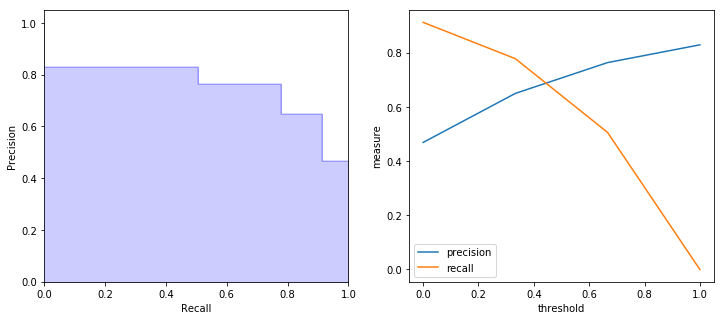

In [96]:
plot_precision_recall(precision,recall,thresholds)

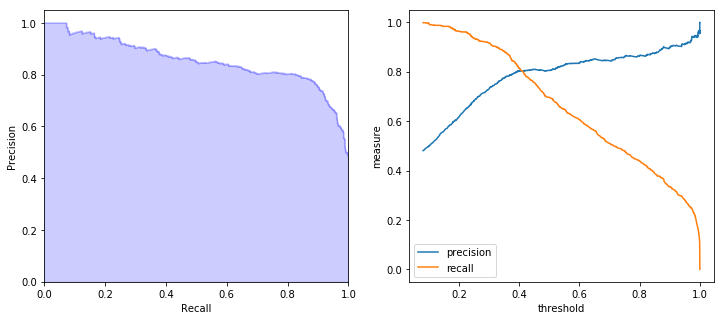

In [97]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression().fit(X_train,y_train)
y_pred_logr = logr.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_logr[:,1])

plot_precision_recall(precision,recall, thresholds)

### f1-score

In [98]:
# F1 = 2 * (precision * recall) / (precision + recall)
# this is at a threshold of 50%!

from sklearn.metrics import f1_score

print('knn  f1score = {:0.2f}'.format(f1_score(y_test,knn.predict(X_test))))
print('logr f1score = {:0.2f}'.format(f1_score(y_test,logr.predict(X_test))))

knn  f1score = 0.77
logr f1score = 0.75


### ROC Curve

True Positive Rate (TPR) = Recall = Sensitivity = TP / (TP + FN)

False Positive Rate (FPR) = FP / (TN + FP)

In [99]:
from sklearn.metrics import roc_curve

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn[:,1])

In [100]:
def plot_roc(curves):
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    lw = 2
    for fpr,tpr,model_name in curves:
        l1, = ax.plot(fpr, tpr, lw=lw, label=model_name)
    ax.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_aspect('equal', 'box')
    ax.set_title('Receiver operating characteristic example')
    ax.legend()

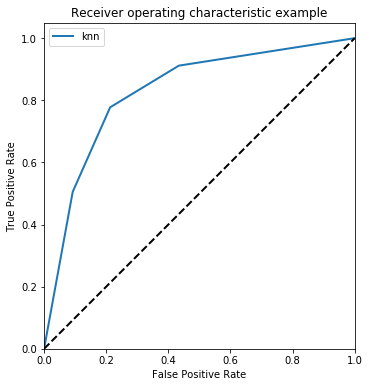

In [101]:
curves = [(fpr_knn,tpr_knn,'knn')]
_ = plot_roc(curves)

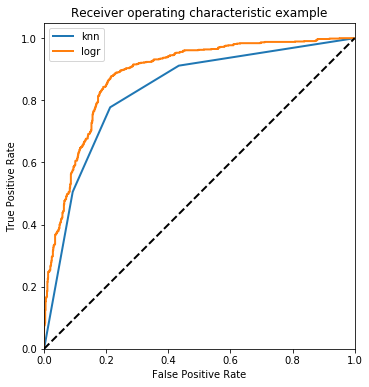

In [102]:
fpr_logr, tpr_logr, _ = roc_curve(y_test, y_pred_logr[:,1])

curves.append((fpr_logr,tpr_logr,'logr'))
_ = plot_roc(curves)

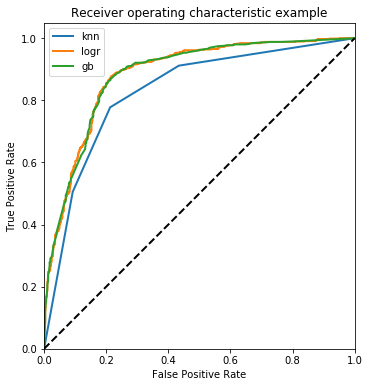

In [103]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators':[10,50,100],
          'max_depth':[2,5,10]}

gb_gs = GridSearchCV(GradientBoostingClassifier(),params,cv=3,n_jobs=-1)
gb_gs.fit(X_train,y_train)
y_pred_gb = gb_gs.predict_proba(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb[:,1])

curves.append((fpr_gb,tpr_gb,'gb'))
_ = plot_roc(curves)

### AUC: Area Under the Curve

In [104]:
from sklearn.metrics import auc

In [105]:
for fpr,tpr,model in curves:
    print('{:5s} auc = {:0.3f}'.format(model,auc(fpr,tpr)))

knn   auc = 0.828
logr  auc = 0.882
gb    auc = 0.882


In [106]:
params = {'n_neighbors': [3,5,10,20,50]}
knn_gs = GridSearchCV(KNeighborsClassifier(),params,n_jobs=-1)
knn_gs.fit(X_train, y_train)
knn_gs.best_params_

{'n_neighbors': 50}

In [107]:
y_pred_knngs = knn_gs.predict_proba(X_test)

fpr_knngs, tpr_knngs, _ = roc_curve(y_test, y_pred_knngs[:,1])
curves.append((fpr_knngs,tpr_knngs,'knn_gs'))
for fpr,tpr,model in curves:
    print('{:6s} auc = {:0.3f}'.format(model,auc(fpr,tpr)))

knn    auc = 0.828
logr   auc = 0.882
gb     auc = 0.882
knn_gs auc = 0.881


## Steps to finding a good model

- set aside test set

- use grid search and cross validation to generate metrics

- compare models on metrics (R^2, RMSE, Accuracy, AUC, ...)

- pick the best and evaluate on test set

### Review

- Accuracy
- Type 1 and 2 error
- Confusion Matrix
- Precision vs. Recall
- ROC Curve
- AUC

## Feature Selection

Reasons to remove features:

- improve score performance (by reducing complexity)

- improve speed performance (by reducing calculations)

- Occam's razor

### By Variance

- low variance features are generally less informative
- sklearn: VarianceThreshold
- by default, removes features with 0 variance
- otherwise, threshold

In [108]:
from sklearn.feature_selection import VarianceThreshold

# remove boolean values with > 80% 1 or 0
# Var[X] = p(1-p)
sel = VarianceThreshold(threshold=.8 * (1 - .8)) 
sel.fit(X_train)

df.columns[1:][sel.get_support()]

Index(['total_time', 'tip_amount', 'pickup_day'], dtype='object')

In [109]:
X_train.shape

(4773, 4)

In [110]:
sel.transform(X_train).shape

(4773, 3)

### Univariate Tests

Perform statistical test on one feature independent of all others

Example: chi squared for classification

- measures dependence between stochastic variables
- finds features least likely to be independent of class
- requires non-negative features

In [111]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# re-normalize features with negative values
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

X_mm = X.copy()
neg_cols = ['trip_distance','total_time']
X_mm[neg_cols] = mm.fit_transform(X[neg_cols])

# resplit data
X_train, X_test, y_train, y_test = train_test_split(X_mm,
                                                    y, 
                                                    test_size=.25,
                                                    stratify=y,
                                                    random_state=0)

# select 2 best features
kbest = SelectKBest(chi2, k=2).fit(X_train, y_train)

In [112]:
# how likely is feature if independence is true
list(sorted(zip(X.columns,kbest.pvalues_),key=lambda x:x[1]))

[('total_time', 2.0041149786233065e-20),
 ('trip_distance', 1.4230756359910157e-19),
 ('pickup_late', 0.14065059981631997),
 ('pickup_day', 0.3553164058283468)]

In [113]:
X_mm.columns[kbest.get_support()]

Index(['trip_distance', 'total_time'], dtype='object')

In [114]:
X_mm_new = kbest.transform(X_mm)

Others in sklearn:

- F-test: captures linear dependency between feature and target
    - f_regression, f_classif

- Mutual Information: captures non-parametric statistical dependency
    - mutual_info_regression, mutual_info_classif

### Stepwise Regression

Successively add and drop predictors to lower a metric (such as AIC).

#### AIC (Akaike's Information Criterion)

- adding features always decreases RMSE and increases R^2
- AIC penalizes adding features to a model

- Unfortunately, no stepwise implementation in sklearn 
- Recursive feature elimination is similar
- other variations: forward selection, backward selection, ...

### Model Based

- Linear Models: non-zero coefficients (ex: LASSO)

In [120]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)

model = SelectFromModel(lsvc, prefit=True)

In [121]:
list(X.columns[model.get_support()])

['total_time', 'pickup_day']

- Trees: feature importances

In [122]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)

model = SelectFromModel(rf, prefit=True)

In [123]:
list(sorted(zip(df.columns[1:],rf.feature_importances_),
            key=lambda x:x[1],
            reverse=True))

[('tip_amount', 0.5851535645840029),
 ('total_time', 0.400808765727467),
 ('pickup_day', 0.0075488664842772585),
 ('pickup_late', 0.00648880320425294)]

In [124]:
list(df.columns[1:].values[model.get_support()])

['total_time', 'tip_amount']